# EMT-MET analysis using the object oriented core

We redesigned the core of Cyclum to a more friendly object oriented core. The core is still under active development, but the major functions are already functional.

We still use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). Tools to transform data are also provided and explained in the following sections.

## Import necessary packages

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import sklearn as skl

In [11]:
import cyclum.tuning
import cyclum.models
from cyclum import writer


## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [12]:
file_name = '''GSM2319557_forebrain_E9.5_embryo1_expression_TPM.txt
GSM2319558_heart_E9.5_embryo1_expression_TPM.txt
GSM2319559_intestine_E9.5_embryo1_expression_TPM.txt
GSM2319560_liver_E9.5_embryo1_expression_TPM.txt
GSM2319561_hindbrain_E9.5_embryo1_expression_TPM.txt
GSM2319562_somite_E9.5_embryo1_expression_TPM.txt
GSM2319563_forebrain_E9.5_embryo2_expression_TPM.txt
GSM2319564_heart_E9.5_embryo2_expression_TPM.txt
GSM2319565_intestine_E9.5_embryo2_expression_TPM.txt
GSM2319566_liver_E9.5_embryo2_expression_TPM.txt
GSM2319567_lung_E9.5_embryo2_expression_TPM.txt
GSM2319568_hindbrain_E9.5_embryo2_expression_TPM.txt
GSM2319569_skin_E9.5_embryo2_expression_TPM.txt
GSM2319570_somite_E9.5_embryo2_expression_TPM.txt
GSM3027032_lung_liver_E9.5_embryo3_expression_TPM.txt
GSM3027033_skin_intestine_somite_E9.5_embryo3_expression_TPM.txt
GSM3027034_forebrain_E10.5_expression_TPM.txt
GSM3027035_heart_E10.5_expression_TPM.txt
GSM3027036_hindbrain_E10.5_expression_TPM.txt
GSM3027037_intestine_E10.5_expression_TPM.txt
GSM3027038_liver_E10.5_expression_TPM.txt
GSM3027039_lung_E10.5_expression_TPM.txt
GSM3027040_skin_E10.5_expression_TPM.txt
GSM3027041_somite_E10.5_expression_TPM.txt
GSM3027042_forebrain_E11.5_expression_TPM.txt
GSM3027043_heart_E11.5_expression_TPM.txt
GSM3027044_hindbrain_E11.5_expression_TPM.txt
GSM3027045_intestine_E11.5_expression_TPM.txt
GSM3027046_liver_E11.5_expression_TPM.txt
GSM3027047_lung_E11.5_expression_TPM.txt
GSM3027048_skin_E11.5_expression_TPM.txt
GSM3027049_somite_E11.5_expression_TPM.txt'''.split('\n')

all_data = [pd.read_csv('/home/shaoheng/Documents/data/EMT/' + i, sep='\t', index_col=0).T for i in file_name];

cell_class = pd.read_csv('/home/shaoheng/Documents/data/EMT/13059_2018_1416_MOESM3_ESM.csv', sep='\t', index_col=0)
cell_class.head()

,Cell_types,PC1,PC2
Cell,,,
intestine_E9.5_embryo1_sc10,Epi,12.554093,1.262988
intestine_E9.5_embryo1_sc11,Epi,10.497880,2.639420
intestine_E9.5_embryo1_sc5,Epi,10.657096,4.028669
intestine_E9.5_embryo1_sc8,Epi,11.485452,4.704812
intestine_E9.5_embryo1_sc9,Epi,9.883902,6.702098


In [13]:
raw_Y = pd.concat(all_data, axis=0, join='inner')

cell_type_list = list(map(lambda x: x.split('_')[0], raw_Y.index.tolist()))

cell_type = pd.DataFrame(index=raw_Y.index, data=cell_type_list)

print("%d cells x %d genes." % raw_Y.shape)
cell_type.head()

1916 cells x 23154 genes.


,0
forebrain_E9.5_embryo1_sc1,forebrain
forebrain_E9.5_embryo1_sc2,forebrain
forebrain_E9.5_embryo1_sc3,forebrain
forebrain_E9.5_embryo1_sc4,forebrain
forebrain_E9.5_embryo1_sc5,forebrain


In [14]:
cell_label = cell_class.loc[raw_Y.index, 'Cell_types']
cell_label = cell_label.dropna()
raw_Y = raw_Y.loc[cell_label.index, :]
cell_type = cell_type.reindex(cell_label.index)
print(f"Epi {np.sum(cell_label.values == 'Epi')}, Mes {np.sum(cell_label.values == 'Mes')}")

Y = skl.preprocessing.scale(np.log1p(raw_Y))

Epi 289, Mes 352


/home/shaoheng/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [17]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=20)
pca_load = pca_model.fit_transform(Y)

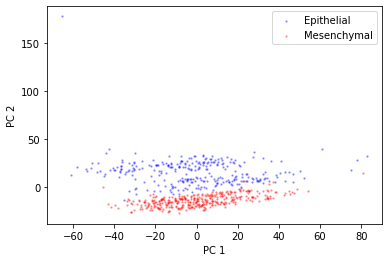

In [30]:
import matplotlib.pyplot as plt

plt.scatter(pca_load[cell_label == 'Epi', 0], pca_load[cell_label == 'Epi', 1], s = 2, c = 'blue', alpha=.3)
plt.scatter(pca_load[cell_label == 'Mes', 0], pca_load[cell_label == 'Mes', 1], s = 2, c = 'red', alpha=.3)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(['Epithelial', 'Mesenchymal'])

plt.savefig("/home/shaoheng/Documents/data/EMT/pca.pdf")

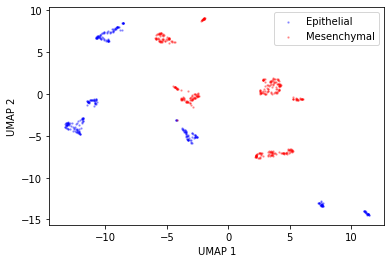

In [29]:
import umap

umap_res = umap.UMAP().fit_transform(pca_load)

plt.scatter(umap_res[cell_label == 'Epi', 0], umap_res[cell_label == 'Epi', 1], s = 2, c = 'blue', alpha=.3)
plt.scatter(umap_res[cell_label == 'Mes', 0], umap_res[cell_label == 'Mes', 1], s = 2, c = 'red', alpha=.3)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(['Epithelial', 'Mesenchymal'])
plt.savefig("/home/shaoheng/Documents/data/EMT/umap.pdf")